In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors

In [2]:
df_2020 = pd.read_csv('../data/topics_2020.csv')
df_2021 = pd.read_csv('../data/topics_2021.csv')
df_2022 = pd.read_csv('../data/topics_2022.csv')
df_2023 = pd.read_csv('../data/topics_2023.csv')

In [3]:
df_2020.head()

,text,yearmonth,title,index,average_toxicity_score,Topic,Count,Name,Representation,Representative_Docs
0,SUTD entry requirements is more or less the sa...,2020-01,sit suss or sutd,0,0.043735,29,213,29_ns_nsf_nsmen_nsfs,"['ns', 'nsf', 'nsmen', 'nsfs', 'nsrelated', 'n...","['So...what is ns....', 'ns', 'Ns']"
1,"With jam like this, it's barely worth it.",2020-01,how congested the ecp is on new years day,1,0.034306,132,64,132_pineapples_pineapple_pineappless_pineapple...,"['pineapples', 'pineapple', 'pineappless', 'pi...","['pineapple tarts are love, pineapple tarts ar..."
2,"I outside now, I guess reaching there around 0...",2020-01,whats the earliest timing i can visit the guan,2,0.077415,343,27,343_slow_slower_speed_faster,"['slow', 'slower', 'speed', 'faster', '24mph',...",['So slow reaction time???.cfm not paying atte...
3,The female or male cry?,2020-01,rsingapore random discussion and small questions,3,0.029896,303,30,303_cry_crying_cried_cries,"['cry', 'crying', 'cried', 'cries', 'tears', '...","[""You should be more worried if she doesn't cr..."
4,bring an umbrella! it gets really hot during t...,2020-01,what is there to prepare for a trip to st johns,4,0.042127,-1,35897,-1_being_really_than_about,"['being', 'really', 'than', 'about', 'im', 'wi...","[""It is good that you care about your mum but ..."


In [4]:
def extract_topic_features(dfs_dict):
    """
    Modified function to include toxicity score aggregation
    """
    topic_data = []
    
    for year, df in dfs_dict.items():
        print(f"Processing {year}...")
        for _, row in df.iterrows():
            try:
                # Handle keywords
                if isinstance(row['Name'], str):
                    if row['Name'].startswith('[') and row['Name'].endswith(']'):
                        keywords = eval(row['Name'])
                    else:
                        keywords = row['Name'].split('_')[1:]
                else:
                    continue
                
                # Handle Representative_Docs
                if isinstance(row['Representative_Docs'], str):
                    rep_docs = eval(row['Representative_Docs'])
                else:
                    rep_docs = row['Representative_Docs'] if isinstance(row['Representative_Docs'], list) else []
                
                keyword_str = ' '.join([str(k) for k in keywords if k and str(k).strip()])
                
                if keyword_str:
                    topic_data.append({
                        'year': year,
                        'yearmonth': row['yearmonth'],
                        'topic_id': row['Topic'],
                        'keywords': keyword_str,
                        'representative_docs': rep_docs,
                        'count': row.get('Count', 0),
                        'toxicity_score': row['average_toxicity_score']
                    })
            except Exception as e:
                print(f"Error processing row in {year}: {e}")
                continue
    
    return pd.DataFrame(topic_data)

In [5]:
# Create dataset
dfs_dict = {
    '2020': df_2020,
    '2021': df_2021,
    '2022': df_2022,
    '2023': df_2023
}

# Print initial stats
print("\nInitial Dataset Statistics:")
for year, df in dfs_dict.items():
    print(f"{year}: {len(df)} rows, {df['Topic'].nunique()} unique topics")

topics_df = extract_topic_features(dfs_dict)
print(f"\nExtracted {len(topics_df)} topic entries")


Initial Dataset Statistics:
2020: 1302526 rows, 1126 unique topics
2021: 1361253 rows, 1329 unique topics
2022: 1042831 rows, 1074 unique topics
2023: 797719 rows, 1002 unique topics
Processing 2020...
Processing 2021...
Processing 2022...
Processing 2023...

Extracted 4501485 topic entries


In [14]:
def clean_topic_keywords(keywords_str):
    # Remove common stopwords and non-meaningful terms
    stopwords = {'than', 'being', 'how', 'will', 'what', 'why', 'when', 'who', 'where', 'about', 'really', 'very', 'just'}
    words = [w for w in keywords_str.split() if w.lower() not in stopwords and len(w) > 2]
    return ' '.join(words)

def get_meaningful_topics(topics_df, min_count=100, top_n_per_year=500):
    print("Processing meaningful topics...")
    
    # First, clean keywords
    topics_df['clean_keywords'] = topics_df['keywords'].apply(clean_topic_keywords)
    
    # Remove topics with empty or non-meaningful keywords
    filtered = topics_df[
        (topics_df['clean_keywords'].str.strip() != '') & 
        (topics_df['count'] >= min_count)
    ]
    print(f"After initial filtering: {len(filtered)} topics")
    
    # Remove duplicates based on year and clean_keywords
    filtered = filtered.drop_duplicates(subset=['year', 'clean_keywords'])
    print(f"After removing duplicates: {len(filtered)} topics")
    
    # Take top N most representative topics per year
    significant = filtered.groupby('year').apply(
        lambda x: x.nlargest(top_n_per_year, 'count')
    ).reset_index(drop=True)
    
    print(f"Final number of significant topics: {len(significant)}")
    
    # Print some statistics
    print("\nTopics per year:")
    print(significant.groupby('year').size())
    
    return significant


In [37]:
def preprocess_topics(topics_df):
    # More comprehensive stopwords
    generic_terms = {
        'singapore', 'singaporean', 'singaporeans', 'because', 'than', 'being', 'about',
        'really', 'very', 'just', 'like', 'get', 'got', 'much', 'many', 'more', 'also',
        'the', 'this', 'that', 'these', 'those', 'there', 'here', 'what', 'when', 'where',
        'who', 'why', 'how', 'which', 'way', 'not', 'can', 'will', 'would', 'should','her','she',
        'they', 'thank', 'thanks', 'thankyou', 'please', 'plz', 'help', 'need', 'want', 'wish',
        'yes','yess','nope'
    }
    
    def clean_keywords(text):
        # Normalize keywords
        words = set(text.lower().split())  # Convert to set to remove duplicates
        words = words - generic_terms  # Remove generic terms
        return ' '.join(sorted(words))  # Sort to make order irrelevant
    
    topics_df['clean_keywords'] = topics_df['clean_keywords'].apply(clean_keywords)
    
    # Remove topics with too few meaningful words
    topics_df = topics_df[topics_df['clean_keywords'].str.split().str.len() >= 2]
    
    return topics_df

In [38]:
meaningful_topics = get_meaningful_topics(topics_df, min_count=100, top_n_per_year=200)
meaningful_topics = preprocess_topics(meaningful_topics)

print("\nSample of meaningful topics:")
print(meaningful_topics[['year', 'topic_id', 'clean_keywords', 'count']].sort_values('count', ascending=False).head(20))

Processing meaningful topics...
After initial filtering: 3474389 topics
After removing duplicates: 3330 topics
Final number of significant topics: 800

Topics per year:
year
2020    200
2021    200
2022    200
2023    200
dtype: int64

Sample of meaningful topics:
     year  topic_id                        clean_keywords  count
0    2020        -1                        opposition pap  84568
200  2021        -1                            covid work  74628
202  2021        -1                       covid time work  64119
203  2021        -1                         chinese covid  61667
204  2021        -1                      covid vaccinated  60027
1    2020        -1                    government workers  58513
207  2021        -1  covid vaccinated vaccination vaccine  56142
3    2020        -1                              job work  53876
4    2020        -1                          job pay work  53387
9    2020         0                             dont work  44767
403  2022        -1 

In [33]:
def find_semantic_clusters(topics_df, min_similarity=0.6):
    # Vectorize with better parameters
    vectorizer = TfidfVectorizer(
        stop_words='english',
        ngram_range=(1, 2),  # Include bigrams
        min_df=2,  # Minimum document frequency
        max_df=0.9  # Maximum document frequency
    )
    
    vectors = vectorizer.fit_transform(topics_df['clean_keywords'])
    
    # Find similar topics
    nn = NearestNeighbors(n_neighbors=min(10, len(topics_df)), 
                         metric='cosine', 
                         algorithm='brute')
    nn.fit(vectors)
    distances, indices = nn.kneighbors(vectors)
    
    # Create graph with stricter similarity threshold
    G = nx.Graph()
    
    for i in range(len(topics_df)):
        G.add_node(i, 
                  year=topics_df.iloc[i]['year'],
                  keywords=topics_df.iloc[i]['clean_keywords'],
                  count=topics_df.iloc[i]['count'])
    
    for i in range(len(indices)):
        for j, dist in zip(indices[i][1:], distances[i][1:]):
            similarity = 1 - dist
            if similarity > min_similarity:
                G.add_edge(i, j, weight=similarity)
    
    # Use a different community detection algorithm
    communities = nx.community.greedy_modularity_communities(G)
    
    return communities, G, vectorizer.get_feature_names_out()

In [41]:
communities, G, feature_names = find_semantic_clusters(meaningful_topics, min_similarity=0.5)

In [20]:
def analyze_semantic_clusters(topics_df, communities):
    cluster_analysis = []
    
    for cluster_id, community in enumerate(communities):
        if len(community) < 2:
            continue
            
        cluster_topics = topics_df.iloc[list(community)]
        
        # Calculate cluster coherence
        keywords = ' '.join(cluster_topics['clean_keywords'])
        unique_keywords = set(keywords.split())
        
        # Get temporal evolution
        year_dist = cluster_topics.groupby('year')['count'].sum()
        
        # Calculate toxicity evolution by month
        toxicity_monthly = cluster_topics.groupby('yearmonth')['toxicity_score'].agg(['mean', 'count']).round(4)
        toxicity_evolution = {
            year: {
                month: {
                    'avg_toxicity': stats['mean'],
                    'post_count': stats['count']
                }
                for month, stats in toxicity_monthly[toxicity_monthly.index.str.startswith(year)].iterrows()
            }
            for year in year_dist.index
        }
        
        # Calculate topic diversity
        topic_diversity = len(unique_keywords) / len(community)
        
        cluster_analysis.append({
            'cluster_id': cluster_id,
            'size': len(community),
            'total_posts': cluster_topics['count'].sum(),
            'unique_keywords': list(unique_keywords),
            'topic_diversity': topic_diversity,
            'temporal_evolution': year_dist.to_dict(),
            'toxicity_evolution': toxicity_evolution,
            'avg_toxicity': cluster_topics['toxicity_score'].mean(),
            'sample_topics': cluster_topics.nlargest(3, 'count')['clean_keywords'].tolist(),
            'topic_indices': list(community)
        })
    
    return pd.DataFrame(cluster_analysis)

In [42]:
cluster_analysis = analyze_semantic_clusters(meaningful_topics, communities)

In [43]:
cluster_analysis.head()

,cluster_id,size,total_posts,unique_keywords,topic_diversity,temporal_evolution,toxicity_evolution,avg_toxicity,sample_topics,topic_indices
0,0,22,141317,"[covidiots, viruses, infected, vaccination, in...",1.227273,"{'2020': 2356, '2021': 135250, '2022': 2978, '...","{'2020': {'2020-01': {'avg_toxicity': 0.0587, ...",0.050925,"[covid vaccinated, covid vaccinated vaccinatio...","[192, 321, 66, 195, 514, 388, 637, 653, 529, 8..."
1,1,20,14679,"[rents, hdbs, housing, homeowners, buyers, nbs...",1.350000,"{'2020': 403, '2021': 4461, '2022': 6891, '202...","{'2020': {'2020-02': {'avg_toxicity': 0.0572, ...",0.086916,"[bto btos hdb housing, btos flats hdb valuatio...","[194, 707, 196, 519, 712, 649, 703, 278, 603, ..."
2,2,17,9207,"[rsg, sgsecure, sgeans, sgraw, sgreans, sgd, s...",0.764706,"{'2020': 1285, '2021': 1376, '2022': 2688, '20...","{'2020': {'2020-02': {'avg_toxicity': 0.0565, ...",0.049124,"[rsg sgraw sgs, sgeans sgraw sgs, sgraw sgs sg...","[481, 389, 425, 201, 75, 409, 587, 655, 559, 6..."
3,3,15,8096,"[cyclist, taxi, bicycle, jaywalking, pedestria...",1.133333,"{'2020': 3858, '2021': 1606, '2022': 762, '202...","{'2020': {'2020-01': {'avg_toxicity': 0.0284, ...",0.056845,"[driving pedestrian pedestrians traffic, drivi...","[577, 70, 264, 9, 235, 14, 591, 497, 689, 52, ..."
4,4,12,7217,"[mask, masks, maskoff, maskless, helmet, maskw...",0.750000,"{'2020': 1558, '2021': 2163, '2022': 3496}","{'2020': {'2020-08': {'avg_toxicity': 0.0425, ...",0.086982,"[mask masking maskoff masks, mask maskless mas...","[128, 385, 223, 132, 267, 109, 302, 210, 406, ..."


In [44]:
# sort by total_post
cluster_analysis.sort_values('total_posts', ascending=False).head(10)

,cluster_id,size,total_posts,unique_keywords,topic_diversity,temporal_evolution,toxicity_evolution,avg_toxicity,sample_topics,topic_indices
56,56,3,183014,"[time, covid, work]",1.000000,"{'2021': 138747, '2022': 44267}","{'2021': {'2021-09': {'avg_toxicity': 0.0539, ...",0.042370,"[covid work, covid time work, covid work]","[184, 369, 183]"
42,42,4,150279,"[employment, work, pay, job, jobs]",1.250000,{'2020': 150279},"{'2020': {'2020-02': {'avg_toxicity': 0.0287, ...",0.039404,"[job work, job pay work, job work]","[2, 3, 5, 22]"
0,0,22,141317,"[covidiots, viruses, infected, vaccination, in...",1.227273,"{'2020': 2356, '2021': 135250, '2022': 2978, '...","{'2020': {'2020-01': {'avg_toxicity': 0.0587, ...",0.050925,"[covid vaccinated, covid vaccinated vaccinatio...","[192, 321, 66, 195, 514, 388, 637, 653, 529, 8..."
79,79,2,82375,"[people, work, dont]",1.500000,{'2020': 82375},"{'2020': {'2020-02': {'avg_toxicity': 0.0393, ...",0.033578,"[dont work, dont people]","[4, 6]"
9,9,10,65735,"[chinesethis, chinese, languages, translates, ...",2.100000,"{'2020': 2145, '2021': 62526, '2022': 427, '20...","{'2020': {'2020-06': {'avg_toxicity': 0.2484, ...",0.055862,"[chinese covid, cantonese chinese dialects man...","[41, 681, 44, 237, 304, 82, 53, 185, 442, 668]"
54,54,3,59198,"[government, ndps, workers, chairman, govt, nd...",2.666667,"{'2020': 58513, '2021': 685}","{'2020': {'2020-04': {'avg_toxicity': 0.0356, ...",0.039268,"[government workers, gov government government...","[1, 282, 334]"
1,1,20,14679,"[rents, hdbs, housing, homeowners, buyers, nbs...",1.350000,"{'2020': 403, '2021': 4461, '2022': 6891, '202...","{'2020': {'2020-02': {'avg_toxicity': 0.0572, ...",0.086916,"[bto btos hdb housing, btos flats hdb valuatio...","[194, 707, 196, 519, 712, 649, 703, 278, 603, ..."
2,2,17,9207,"[rsg, sgsecure, sgeans, sgraw, sgreans, sgd, s...",0.764706,"{'2020': 1285, '2021': 1376, '2022': 2688, '20...","{'2020': {'2020-02': {'avg_toxicity': 0.0565, ...",0.049124,"[rsg sgraw sgs, sgeans sgraw sgs, sgraw sgs sg...","[481, 389, 425, 201, 75, 409, 587, 655, 559, 6..."
3,3,15,8096,"[cyclist, taxi, bicycle, jaywalking, pedestria...",1.133333,"{'2020': 3858, '2021': 1606, '2022': 762, '202...","{'2020': {'2020-01': {'avg_toxicity': 0.0284, ...",0.056845,"[driving pedestrian pedestrians traffic, drivi...","[577, 70, 264, 9, 235, 14, 591, 497, 689, 52, ..."
4,4,12,7217,"[mask, masks, maskoff, maskless, helmet, maskw...",0.750000,"{'2020': 1558, '2021': 2163, '2022': 3496}","{'2020': {'2020-08': {'avg_toxicity': 0.0425, ...",0.086982,"[mask masking maskoff masks, mask maskless mas...","[128, 385, 223, 132, 267, 109, 302, 210, 406, ..."


In [55]:
# sort by average toxicity score
cluster_analysis.sort_values('avg_toxicity', ascending=False).head(20)

,cluster_id,size,total_posts,unique_keywords,topic_diversity,temporal_evolution,toxicity_evolution,avg_toxicity,sample_topics,topic_indices
99,99,2,1118,"[policeman, arrest, reports, cops, police]",2.500000,"{'2020': 742, '2021': 376}","{'2020': {'2020-12': {'avg_toxicity': 0.0339, ...",0.216664,"[arrest cops police policeman, arrest cops pol...","[26, 285]"
142,142,2,797,"[football, footballer, footballing, footballers]",2.000000,"{'2021': 524, '2023': 273}","{'2021': {'2021-06': {'avg_toxicity': 0.0595, ...",0.175611,"[football footballer footballers footballing, ...","[705, 234]"
141,141,2,1176,"[drugs, marijuana, weed, cannabis]",2.000000,{'2023': 1176},"{'2023': {'2023-05': {'avg_toxicity': 0.2422, ...",0.173767,"[cannabis drugs marijuana weed, cannabis drugs...","[563, 686]"
59,59,3,2486,"[crimea, nato, ukraines, ukraine]",1.333333,{'2022': 2486},"{'2022': {'2022-02': {'avg_toxicity': 0.031, '...",0.149231,"[crimea nato ukraine ukraines, crimea nato ukr...","[416, 428, 374]"
134,134,2,1541,"[him, tharman, role, tharma, nathan, tharmans]",3.000000,{'2023': 1541},"{'2023': {'2023-06': {'avg_toxicity': 0.0382, ...",0.141764,"[him role tharman tharmans, nathan tharma thar...","[651, 558]"
125,125,2,1173,"[comedic, laughed, joke, humor, funny, jokes]",3.000000,"{'2021': 345, '2023': 828}","{'2021': {'2021-05': {'avg_toxicity': 0.041, '...",0.129979,"[comedic humor joke jokes, funny joke jokes la...","[306, 566]"
31,31,6,3953,"[lgbts, heterosexual, lgbt, homosexuality, hom...",2.000000,"{'2020': 1023, '2022': 2685, '2023': 245}","{'2020': {'2020-06': {'avg_toxicity': 0.0356, ...",0.123047,"[homosexuality lgbt lgbtq repeal, homophobic h...","[96, 530, 371, 404, 40, 734]"
130,130,2,989,"[cctvs, cameras, consent, filmed, cctv, filmin...",3.500000,{'2023': 989},"{'2023': {'2023-08': {'avg_toxicity': 0.0618, ...",0.120415,"[camera cameras cctv cctvs, camera consent fil...","[616, 590]"
28,28,6,3338,"[wage, salaries, income, unemployment, office,...",1.666667,"{'2020': 2234, '2021': 356, '2022': 383, '2023...","{'2020': {'2020-02': {'avg_toxicity': 0.0497, ...",0.111570,"[income unemployment wage wages, payouts pays ...","[125, 646, 71, 8, 300, 461]"
61,61,3,1708,"[christianity, religions, religion, religious,...",1.666667,"{'2020': 464, '2022': 1244}","{'2020': {'2020-10': {'avg_toxicity': 0.203, '...",0.107257,"[religion religions religious secular, christi...","[73, 386, 457]"


In [47]:
# Print results with better formatting
print("\nMeaningful Topic Clusters:")
for _, cluster in cluster_analysis.sort_values('total_posts', ascending=False).head(10).iterrows():
    print(f"\nCluster {cluster['cluster_id']}")
    print(f"Size: {cluster['size']} topics")
    print(f"Total posts: {cluster['total_posts']:,}")
    print(f"Topic diversity: {cluster['topic_diversity']:.2f}")
    print("Unique keywords:", ', '.join(sorted(cluster['unique_keywords'])))
    print("Sample topics:", cluster['sample_topics'])
    print("Temporal evolution:", cluster['temporal_evolution'])
    print("-" * 50)


Meaningful Topic Clusters:

Cluster 56
Size: 3 topics
Total posts: 183,014
Topic diversity: 1.00
Unique keywords: covid, time, work
Sample topics: ['covid work', 'covid time work', 'covid work']
Temporal evolution: {'2021': 138747, '2022': 44267}
--------------------------------------------------

Cluster 42
Size: 4 topics
Total posts: 150,279
Topic diversity: 1.25
Unique keywords: employment, job, jobs, pay, work
Sample topics: ['job work', 'job pay work', 'job work']
Temporal evolution: {'2020': 150279}
--------------------------------------------------

Cluster 0
Size: 22 topics
Total posts: 141,317
Topic diversity: 1.23
Unique keywords: coronavirus, covid, covid19, covid19s, covidiots, covids, fishery, flu, infect, infected, infectious, jurong, outbreak, pandemic, precovid, quarantine, quarantined, quarantines, singapores, sinovac, vaccinated, vaccination, vaccinations, vaccine, vaccines, virus, viruses
Sample topics: ['covid vaccinated', 'covid vaccinated vaccination vaccine', 'c

In [46]:
# save data
cluster_analysis.to_csv('../data/topic_clusters.csv', index=False)

In [48]:
cluster = pd.read_csv('../data/topic_clusters.csv')

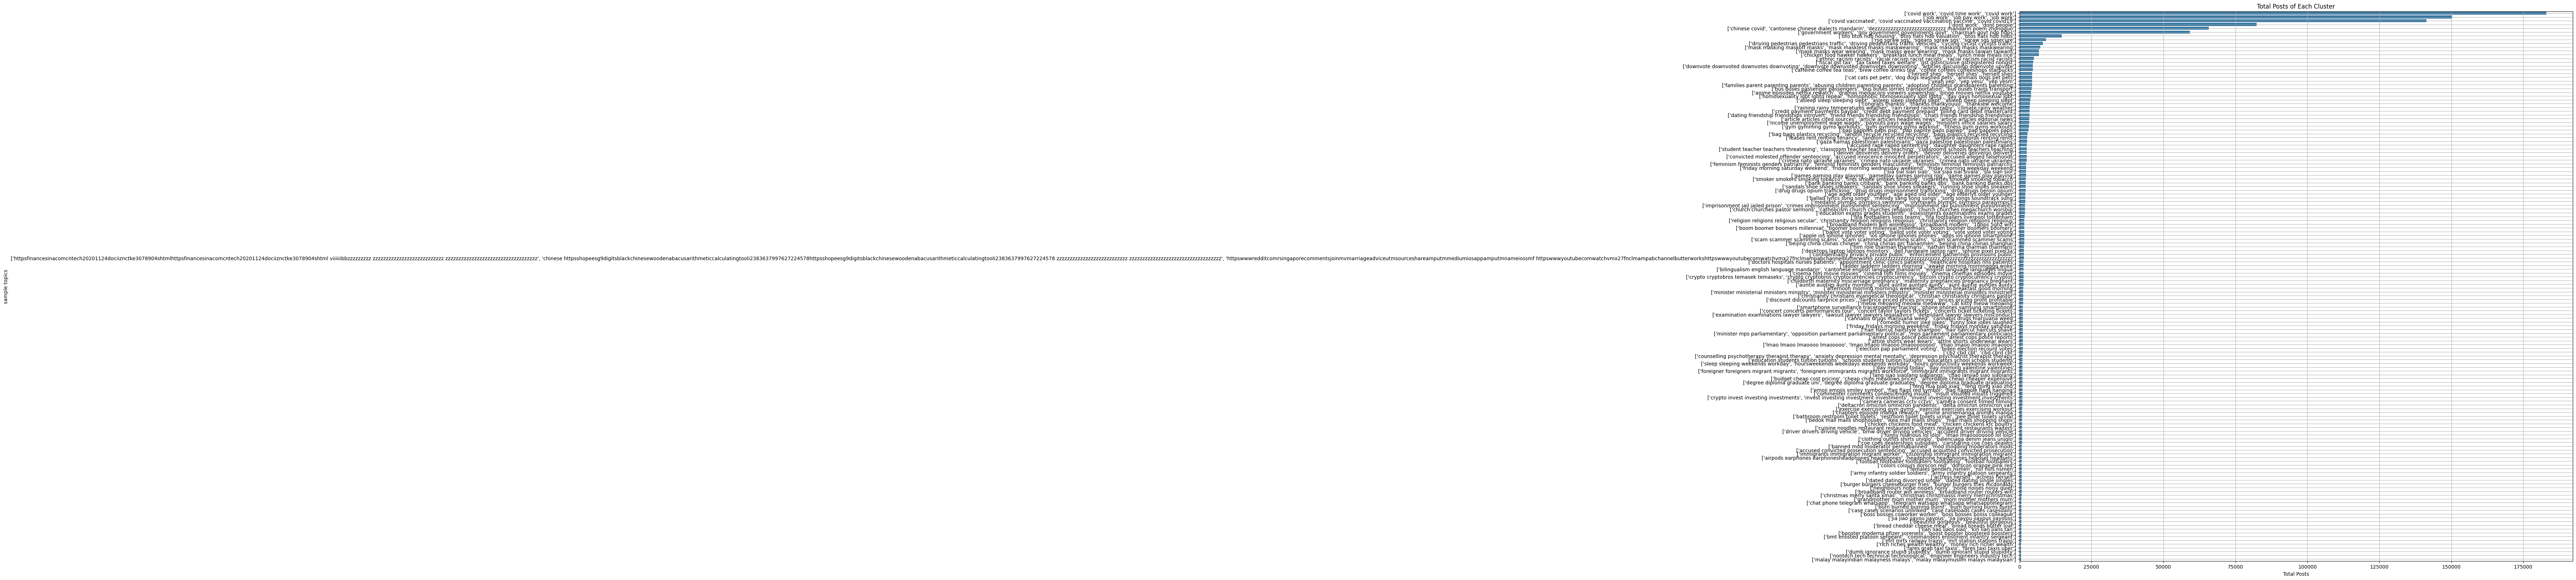

In [49]:
# bar plot of total_post of each cluster
# plot sort by total_post
cluster = cluster.sort_values('total_posts', ascending=False)
plt.figure(figsize=(20, 20))
sns.barplot(y='sample_topics', x='total_posts', data=cluster)
plt.title('Total Posts of Each Cluster')
plt.ylabel('sample topics')
plt.xlabel('Total Posts')
plt.grid(True)
plt.show()

In [50]:
def plot_top_topics_by_year(cluster_df):
    plt.style.use('seaborn')
    
    # Get unique years from temporal evolution
    all_years = set()
    for _, cluster in cluster_df.iterrows():
        temporal_evolution = eval(cluster['temporal_evolution'])
        all_years.update(temporal_evolution.keys())
    
    # Create a subplot for each year
    n_years = len(all_years)
    fig = plt.figure(figsize=(15, 5*n_years))
    
    for idx, year in enumerate(sorted(all_years), 1):
        # Get posts for this year
        year_data = []
        for _, cluster in cluster_df.iterrows():
            temporal_evolution = eval(cluster['temporal_evolution'])
            if year in temporal_evolution:
                year_data.append({
                    'cluster_id': cluster['cluster_id'],
                    'posts': temporal_evolution[year],
                    'keywords': ', '.join(eval(cluster['unique_keywords'])[:3])
                })
        
        # Convert to DataFrame and get top 10
        year_df = pd.DataFrame(year_data)
        top_10 = year_df.nlargest(10, 'posts')
        
        # Create subplot
        plt.subplot(n_years, 1, idx)
        
        # Create bar plot
        bars = plt.bar(range(len(top_10)), top_10['posts'], 
                      color=plt.cm.viridis(np.linspace(0, 1, len(top_10))))
        
        # Customize plot
        plt.title(f'Top 10 Topics in {year}', pad=20, fontsize=14)
        plt.ylabel('Number of Posts', fontsize=12)
        
        # Rotate x-labels for better readability
        plt.xticks(range(len(top_10)), 
                  [f"Cluster {row['cluster_id']}\n{row['keywords']}" for _, row in top_10.iterrows()],
                  rotation=45, ha='right')
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom')
        
        # Add grid for better readability
        plt.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table for each year
    for year in sorted(all_years):
        print(f"\nTop 10 Topics in {year}:")
        year_data = []
        for _, cluster in cluster_df.iterrows():
            temporal_evolution = eval(cluster['temporal_evolution'])
            if year in temporal_evolution:
                year_data.append({
                    'Cluster': cluster['cluster_id'],
                    'Keywords': ', '.join(eval(cluster['unique_keywords'])[:3]),
                    'Posts': temporal_evolution[year]
                })
        year_df = pd.DataFrame(year_data)
        print(year_df.nlargest(10, 'Posts').to_string(index=False))
        print("-" * 50)

C:\Users\ch8765\AppData\Local\Temp\ipykernel_16276\3253853316.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


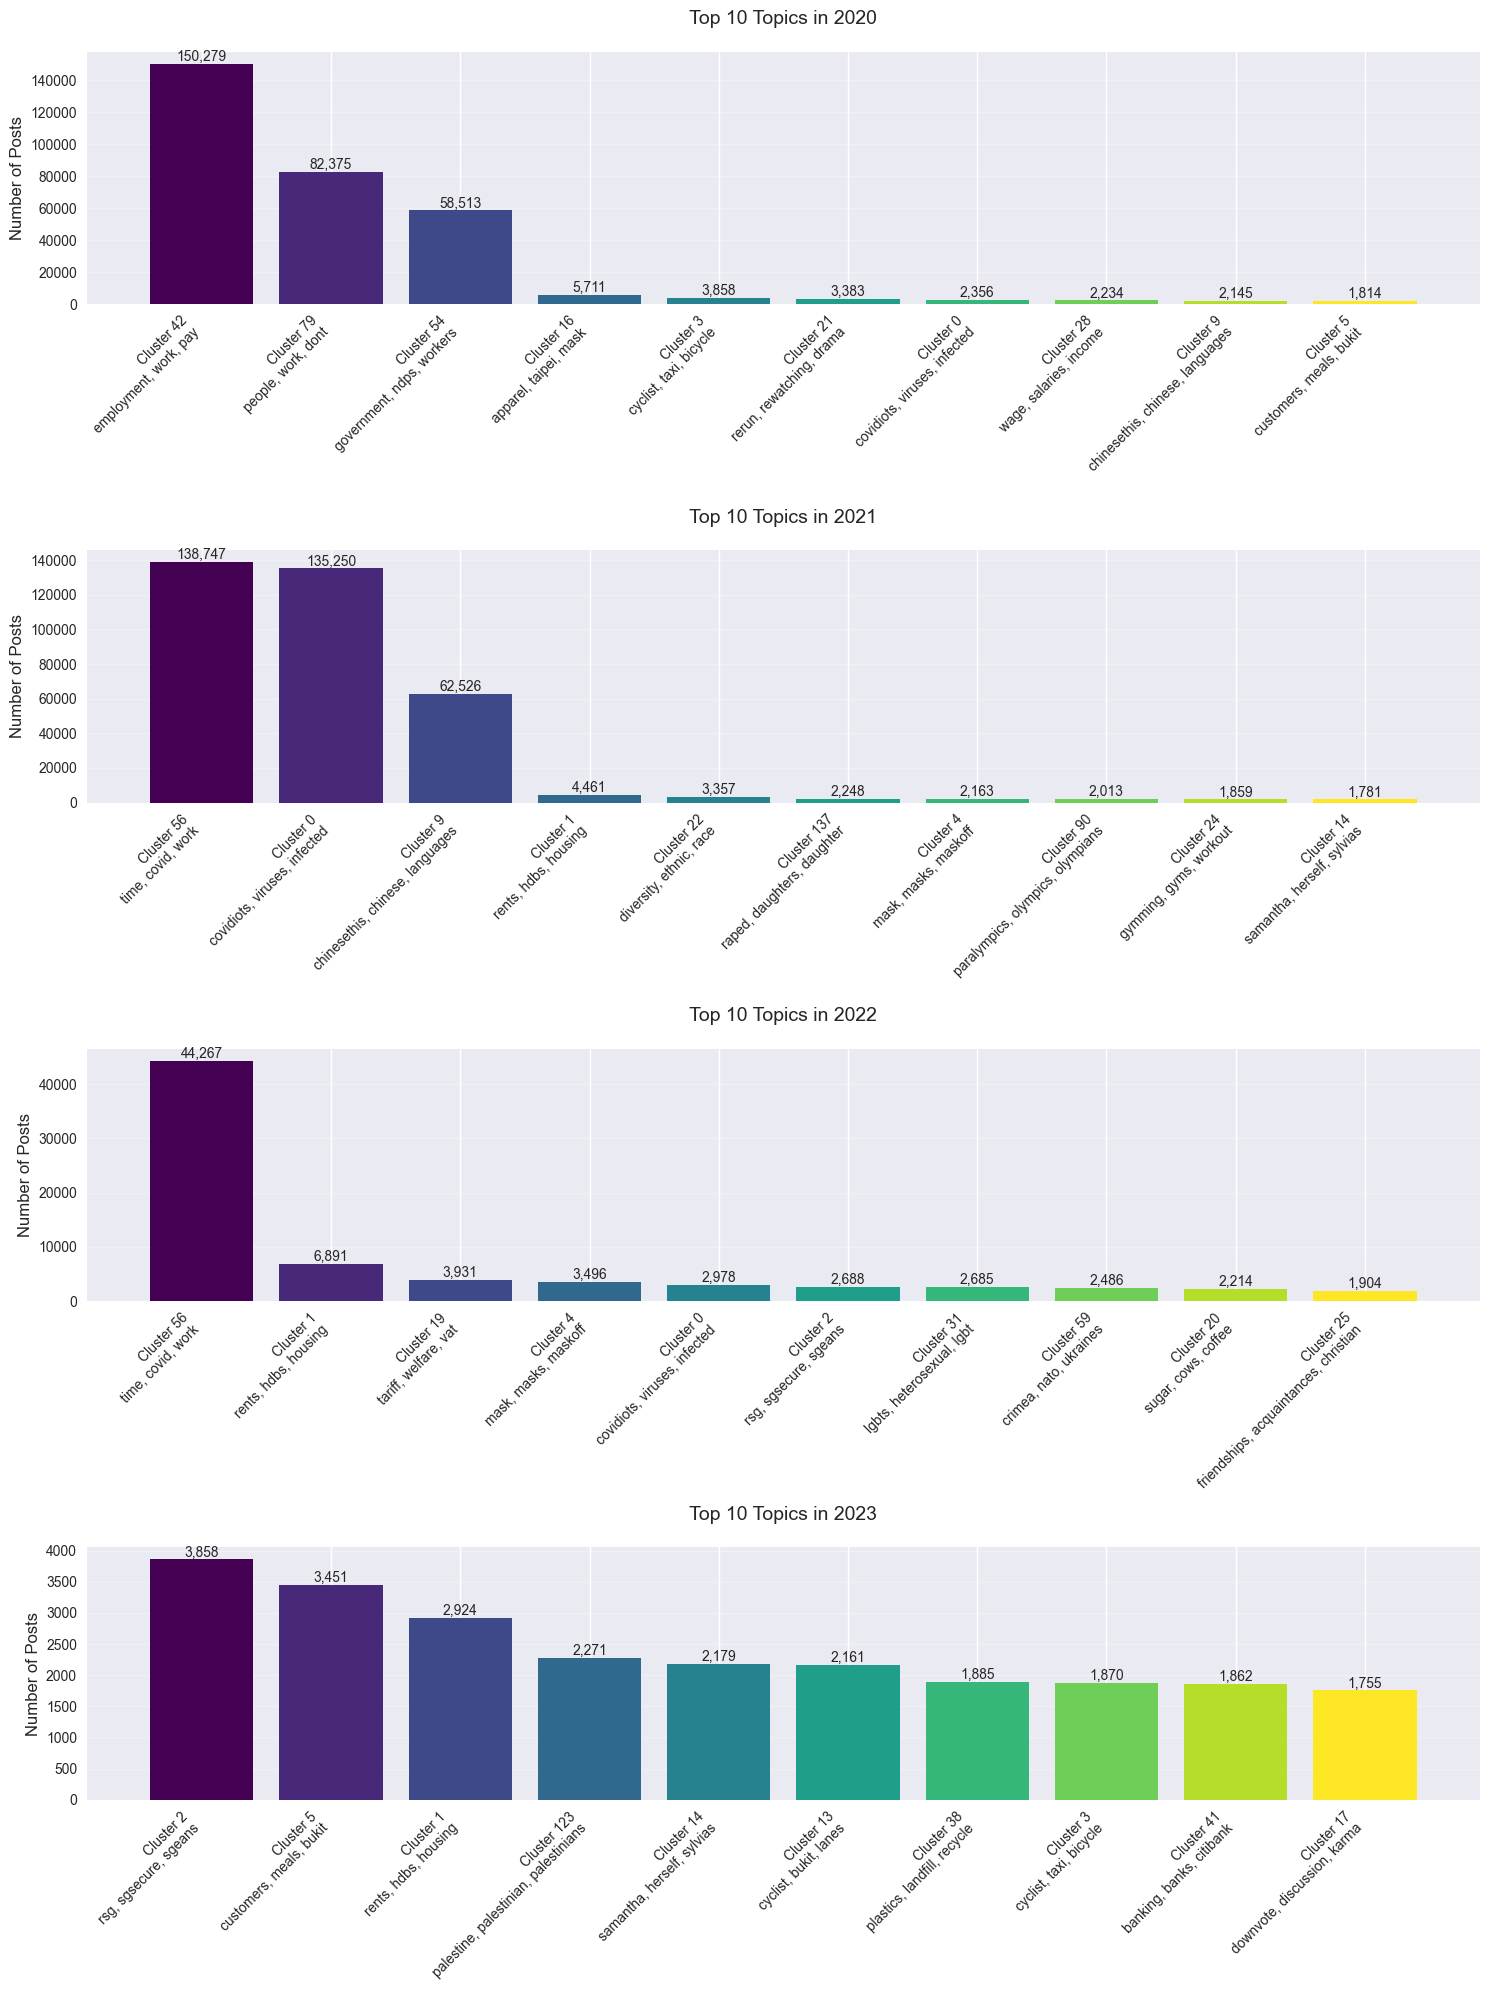


Top 10 Topics in 2020:
 Cluster                        Keywords  Posts
      42           employment, work, pay 150279
      79              people, work, dont  82375
      54       government, ndps, workers  58513
      16           apparel, taipei, mask   5711
       3          cyclist, taxi, bicycle   3858
      21        rerun, rewatching, drama   3383
       0    covidiots, viruses, infected   2356
      28          wage, salaries, income   2234
       9 chinesethis, chinese, languages   2145
       5         customers, meals, bukit   1814
--------------------------------------------------

Top 10 Topics in 2021:
 Cluster                         Keywords  Posts
      56                time, covid, work 138747
       0     covidiots, viruses, infected 135250
       9  chinesethis, chinese, languages  62526
       1             rents, hdbs, housing   4461
      22          diversity, ethnic, race   3357
     137       raped, daughters, daughter   2248
       4             mask, mas

In [51]:
plot_top_topics_by_year(cluster)